## Step 1 - assign appropriate Label to each row of Bow/TF-IDF representation

In [22]:
import numpy as np

authors = np.load("../data/1.3-bow-authors.npy", allow_pickle=True)
print(authors)
print(authors.shape)
authors2 = np.load("../data/1.3-tf-idf-authors.npy", allow_pickle=True)
print(authors2)
print(authors2.shape)

if np.array_equal(authors,authors2): #expected. Just to check.
    print("true")


['-Jared' '-Peeter' '-evasian' ... 'zukinzo' 'zzrr' 'zzuil93']
(4994,)
['-Jared' '-Peeter' '-evasian' ... 'zukinzo' 'zzrr' 'zzuil93']
(4994,)
true


In [23]:
from scipy import sparse

X_bow_quantile = sparse.load_npz("../data/1.4-bow_filtered_quantile.npz")
X_tfidf_quantile = sparse.load_npz("../data/1.4-tfidf_filtered_quantile.npz")

print(X_bow_quantile.shape)
print(X_tfidf_quantile.shape)

(4994, 53656)
(4994, 53656)


In [24]:
X_bow_svd = np.load("../data/1.4-bow_svd_reduced.npy")
X_tfidf_svd = np.load("../data/1.4-tfidf_svd_reduced.npy")

print(X_bow_svd.shape)
print(X_tfidf_svd.shape)

(4994, 1000)
(4994, 1000)


In [25]:
import pandas as pd
Target = pd.read_csv("../data/target_supervised.csv")

labels = []

for auth in authors:
    # Try to find the first matching row for this author
    match = Target[Target['author'] == auth]

    if not match.empty:
        labels.append(match['gender'].iloc[0])
        #print(match['gender'].iloc[0])
    else:
        print("error")


print(len(labels))
print(labels)

4994
[np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int

## step 2 Perform the train test split for all

In [26]:
from sklearn.model_selection import train_test_split
Y = labels

#split 80-10-10
X_bowsvd_temp, X_bowsvd_test, y_bowsvd_temp, y_bowsvd_test = train_test_split(X_bow_svd,labels, stratify=labels, train_size=0.90,random_state=16)
X_bowsvd_train, X_bowsvd_val, y_bowsvd_train, y_bowsvd_val = train_test_split(X_bowsvd_temp, y_bowsvd_temp, stratify=y_bowsvd_temp, train_size=8/9, random_state=16)

print(X_bowsvd_train.shape)
print(X_bowsvd_val.shape)
print(X_bowsvd_test.shape)

(3994, 1000)
(500, 1000)
(500, 1000)


In [27]:
X_bowquantile_temp, X_bowquantile_test, y_bowquantile_temp, y_bowquantile_test = train_test_split(X_bow_quantile,labels, stratify=labels, train_size=0.90,random_state=16)
X_bowquantile_train, X_bowquantile_val, y_bowquantile_train, y_bowquantile_val = train_test_split(X_bowquantile_temp, y_bowquantile_temp, stratify=y_bowquantile_temp, train_size=8/9, random_state=16)

print(X_bowquantile_train.shape)
print(X_bowquantile_val.shape)
print(X_bowquantile_test.shape)

(3994, 53656)
(500, 53656)
(500, 53656)


In [28]:
#split 80-10-10
X_tfidfsvd_temp, X_tfidfsvd_test, y_tfidfsvd_temp, y_tfidfsvd_test = train_test_split(X_tfidf_svd,labels, stratify=labels, train_size=0.90,random_state=16)
X_tfidfsvd_train, X_tfidfsvd_val, y_tfidfsvd_train, y_tfidfsvd_val = train_test_split(X_tfidfsvd_temp, y_tfidfsvd_temp, stratify=y_tfidfsvd_temp, train_size=8/9, random_state=16)

print(X_tfidfsvd_train.shape)
print(X_tfidfsvd_val.shape)
print(X_tfidfsvd_test.shape)

(3994, 1000)
(500, 1000)
(500, 1000)


In [29]:
X_tfidfquantile_temp, X_tfidfquantile_test, y_tfidfquantile_temp, y_tfidfquantile_test = train_test_split(X_tfidf_quantile,labels, stratify=labels, train_size=0.90,random_state=16)
X_tfidfquantile_train, X_tfidfquantile_val, y_tfidfquantile_train, y_tfidfquantile_val = train_test_split(X_tfidfquantile_temp, y_tfidfquantile_temp, stratify=y_tfidfquantile_temp, train_size=8/9, random_state=16)

print(X_tfidfquantile_train.shape)
print(X_tfidfquantile_val.shape)
print(X_tfidfquantile_test.shape)

(3994, 53656)
(500, 53656)
(500, 53656)


## Multinomial Naive Bayes


In [30]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler

### Defining the functions 

In [31]:
# choosing the top K features with more informations with a chi-square 
# return choosen features  for train and validation

def select_top_k_features(X_train, y_train, X_val, k=10000):
    selector = SelectKBest(chi2, k=k)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_val_sel = selector.transform(X_val)

    return X_train_sel, X_val_sel, selector

In [32]:
# oversampling of minority class

def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X_bal, y_bal = ros.fit_resample(X, y)
    return X, y_bal

In [45]:
def train_multinomialNB(X_train, y_train, batch_size=256, alpha=1.0):

    #model multinomial Naive Bayes
    classifier = MultinomialNB(alpha=alpha, force_alpha=True, fit_prior=True)
    
    # fit the model with partial fitting using batch(to save the RAM)
    first = True
    n = X_train.shape[0]

    # generation of batch
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)  # assicura che l'ultimo batch non superi il numero di campioni
        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        if first:
            classifier.partial_fit(X_batch, y_batch, classes=[0,1])
            first = False
        else:
            classifier.partial_fit(X_batch, y_batch)

    return classifier


In [46]:
def train_complementNB(X_train, y_train, batch_size=256, alpha=1.0):

    classifier = ComplementNB(alpha=alpha)
    
    # fit the model with partial fitting using batch(to save the RAM)
    n = X_train.shape[0]
    indices = np.random.permutation(n)
    

    first = True


    # generation of batch
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)  # assicura che l'ultimo batch non superi il numero di campioni

        batch_idz = indices[i:end]
        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        if first:
            classifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            first = False
        else:
            classifier.partial_fit(X_batch, y_batch)
     

    return classifier

In [35]:
def evaluate_model(classifier, X_train, y_train, X_val, y_val, dataset=""):

    # predictions
    y_pred_train = classifier.predict(X_train)
    y_pred_val = classifier.predict(X_val)


    print(f"Info about: {dataset}")

    # evaluating performances

    conf_matrix = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    print(f"Classification report validation:\n{classification_report(y_val,y_pred_val)}")
    print(f"Classification report training:\n{classification_report(y_train,y_pred_train)}")




### Hyperparameter tuning
Alpha il the Laplace smoothing and it is useful to avoid that a word with count 0 drop to 0 the probability of the relegated class.

In [36]:
def tune_alpha_nb(X_train, y_train, X_val, y_val, type=0):

    best_alpha = None
    best_f1 = 0
    best_clf = None

    alpha_list = [0.1, 0.5, 1.0, 2.0, 5.0]

    for alpha in alpha_list:

        if type == 0:
            classifier = train_multinomialNB(X_train, y_train, batch_size=256, alpha=alpha)
        else:
            classifier = train_complementNB(X_train, y_train, batch_size=256, alpha=alpha)
        y_val_pred = classifier.predict(X_val)
        report = classification_report(y_val, y_val_pred, output_dict=True)
        f1_macro = report['macro avg']['f1-score']

        
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_alpha = alpha
            best_clf = classifier

    print(f"Best alpha: {best_alpha}, Macro F1: {best_f1:.4f}")
    return best_clf, best_alpha
        

### Use of Bow
Applying the Multinomial Naive Bayes to the BoW.

Info about: BoW quantile
Classification report validation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       365
           1       0.68      0.67      0.68       135

    accuracy                           0.83       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.83      0.83      0.83       500

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2916
           1       0.74      0.78      0.76      1078

    accuracy                           0.87      3994
   macro avg       0.83      0.84      0.84      3994
weighted avg       0.87      0.87      0.87      3994



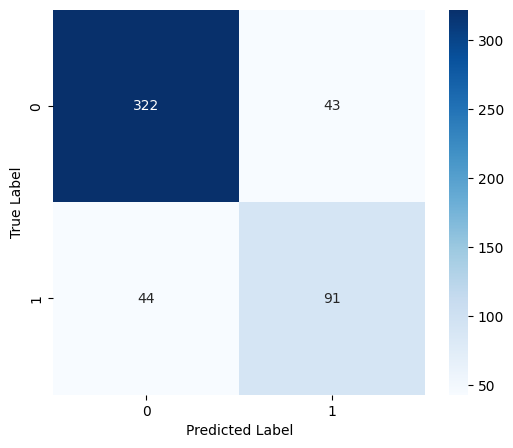

In [ ]:
# Evaluating model 
X_train_, X_val_, selector = select_top_k_features(X_bowquantile_train, y_bowquantile_train,X_bowquantile_val, k=10000)

X_train_balanced, y_train_balanced = balance_classes(X_train_, y_bowquantile_train)

multinomial_nb = train_multinomialNB(X_train_balanced, y_train_balanced, batch_size=256, alpha=1.0)

evaluate_model(multinomial_nb, X_train_, y_bowquantile_train, X_val_, y_bowquantile_val, dataset="BoW quantile")


Info about: BoW quantile - Test
Classification report validation:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       365
           1       0.62      0.56      0.59       135

    accuracy                           0.79       500
   macro avg       0.73      0.71      0.72       500
weighted avg       0.78      0.79      0.78       500

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2916
           1       0.74      0.78      0.76      1078

    accuracy                           0.87      3994
   macro avg       0.83      0.84      0.84      3994
weighted avg       0.87      0.87      0.87      3994



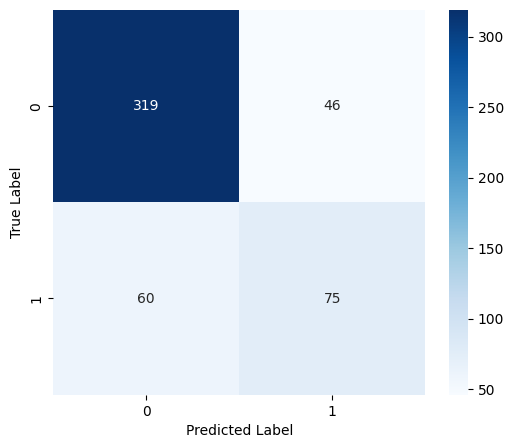

In [38]:
# evaluating the test set
X_bowquantile_test_ = selector.transform(X_bowquantile_test)

evaluate_model(
    multinomial_nb,
    X_train_, y_bowquantile_train, 
    X_bowquantile_test_, y_bowquantile_test,    # test set
    dataset="BoW quantile - Test"
)



Best alpha: 2.0, Macro F1: 0.7838
Info about: BoW Quantile Top-K + Oversampling
Classification report validation:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       365
           1       0.70      0.67      0.68       135

    accuracy                           0.83       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.83      0.83      0.83       500

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2916
           1       0.75      0.78      0.76      1078

    accuracy                           0.87      3994
   macro avg       0.83      0.84      0.83      3994
weighted avg       0.87      0.87      0.87      3994



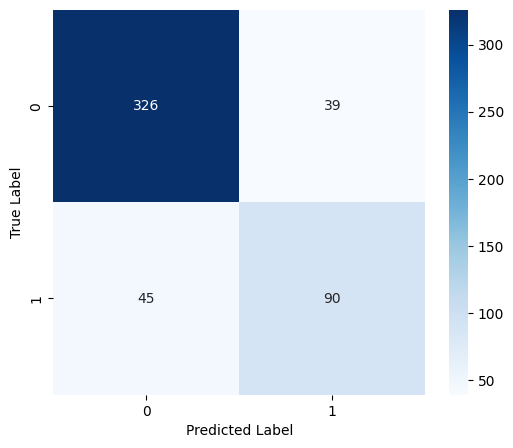

In [44]:
# Tuning aplha

# Step 1: selection of top-k
X_train_sel, X_val_sel, selector = select_top_k_features(X_bowquantile_train, y_bowquantile_train, X_bowquantile_val, k=10000)

# Step 2: oversampling
X_train_bal, y_train_bal = balance_classes(X_train_sel, y_bowquantile_train)

# Step 3: tuning alpha
best_model, best_alpha = tune_alpha_nb(X_train_bal, y_train_bal, X_val_sel, y_bowquantile_val, type=0)

# Step 4: valutazione finale
evaluate_model(best_model, X_train_sel, y_bowquantile_train, X_val_sel, y_bowquantile_val, dataset="BoW Quantile Top-K + Oversampling")


### Use of TF-IDF
We should use Complement NB to avoid the problem to drop to 0 when a feature is less or equal than 0.
MultinomialNB works well only when the features are non negative integers.

Info about: TD-IDF Quantile
Classification report validation:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       365
           1       0.67      0.43      0.52       135

    accuracy                           0.79       500
   macro avg       0.74      0.68      0.69       500
weighted avg       0.77      0.79      0.77       500

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2916
           1       0.95      0.77      0.85      1078

    accuracy                           0.93      3994
   macro avg       0.93      0.88      0.90      3994
weighted avg       0.93      0.93      0.92      3994



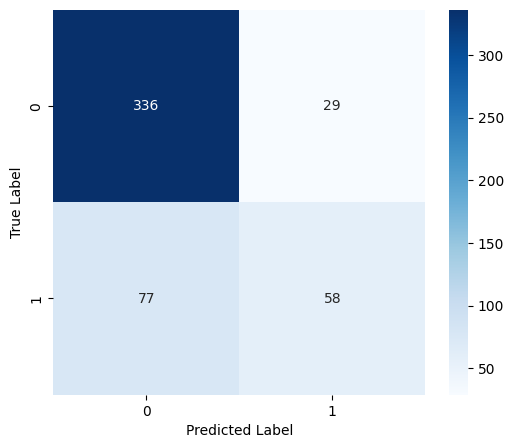

In [50]:
# Evaluating model 
X_train_, X_val_, selector = select_top_k_features(X_tfidfquantile_train, y_tfidfquantile_train,X_tfidfquantile_val, k=10000)

X_train_balanced, y_train_balanced = balance_classes(X_train_, y_tfidfquantile_train)

multinomial_nb = train_complementNB(X_train_balanced, y_train_balanced, batch_size=256, alpha=1.0)

evaluate_model(multinomial_nb, X_train_, y_tfidfquantile_train, X_val_, y_tfidfquantile_val, dataset="TD-IDF Quantile")

Info about: TD-IDF quantile - Test
Classification report validation:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       365
           1       0.63      0.32      0.42       135

    accuracy                           0.77       500
   macro avg       0.71      0.63      0.64       500
weighted avg       0.75      0.77      0.74       500

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2916
           1       0.95      0.77      0.85      1078

    accuracy                           0.93      3994
   macro avg       0.93      0.88      0.90      3994
weighted avg       0.93      0.93      0.92      3994



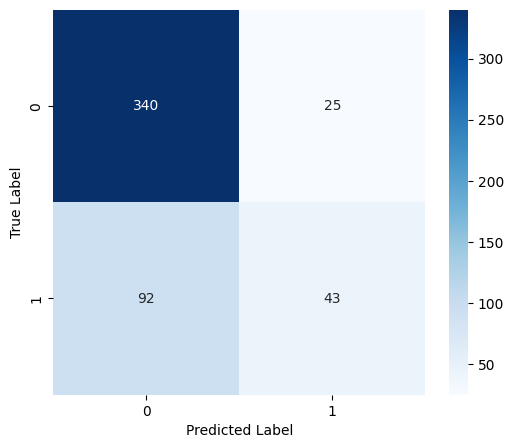

In [51]:
# evaluating the test set
X_tfidfquantile_test_ = selector.transform(X_bowquantile_test)

evaluate_model(
    multinomial_nb,
    X_train_, y_tfidfquantile_train, 
    X_tfidfquantile_test_, y_tfidfquantile_test,    # test set
    dataset="TD-IDF quantile - Test"
)

Best alpha: 0.1, Macro F1: 0.7522
Info about: TF-IDF + ComplementNB
Classification report validation:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       365
           1       0.61      0.68      0.65       135

    accuracy                           0.80       500
   macro avg       0.75      0.76      0.75       500
weighted avg       0.81      0.80      0.80       500

Classification report training:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2916
           1       0.88      0.94      0.91      1078

    accuracy                           0.95      3994
   macro avg       0.93      0.95      0.94      3994
weighted avg       0.95      0.95      0.95      3994



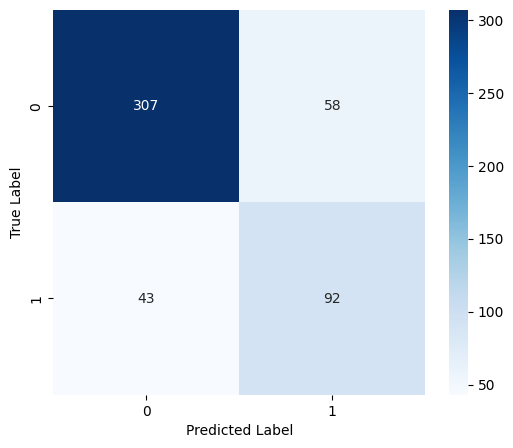

In [47]:
# Top-K + oversampling
X_train_tf_topk, X_val_tf_topk, selector_tf = select_top_k_features(X_tfidfquantile_train, y_tfidfquantile_train, X_tfidfquantile_val, k=10000)
X_train_tf_bal, y_train_tf_bal = balance_classes(X_train_tf_topk, y_tfidfquantile_train)

# Tuning alpha
clf_best, best_alpha = tune_alpha_nb(X_train_tf_bal, y_train_tf_bal, X_val_tf_topk, y_tfidfquantile_val, type=1)

# Eval finale
evaluate_model(clf_best, X_train_tf_topk, y_tfidfquantile_train, X_val_tf_topk, y_tfidfquantile_val, dataset="TF-IDF + ComplementNB")


### Evaluating the performances
#### Accuracy
It is the number of right predictions on whole samples

#### Precision
It indicates how much times the model predicts a class X and how it was really belonging to that class. --> ( TP) / (TP + FP)

#### Recall or sensibility
How much samples belonging to a certain class X are we losing?
--> TP / (TP + FN)

#### F1-score
Armonic mean between precision and recall, it indicates how much the classess are balanced

### Analysis
### Class 0
Precision 0.75
Recall 0.75
f1-score 0.74
It looks Ok, the model well recognize the dominant class
### Class 1
Precision 0.33
Recall 0.33
F1-score

--> We are having overfitting